## from_segmentation

> Create a half-edge mesh from a segmentation

In [ ]:
#| default_exp segmentation

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| export

from skimage import measure, segmentation, future
import networkx as nx

In [ ]:
#| notest

import importlib

In [ ]:
importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

## Code copied from `skimage` to reduce numbers of dependencies

In [ ]:
def expand_labels(label_image, distance=1):
    """Expand labels in label image by ``distance`` pixels without overlapping.
    Given a label image, ``expand_labels`` grows label regions (connected components)
    outwards by up to ``distance`` pixels without overflowing into neighboring regions.
    More specifically, each background pixel that is within Euclidean distance
    of <= ``distance`` pixels of a connected component is assigned the label of that
    connected component.
    Where multiple connected components are within ``distance`` pixels of a background
    pixel, the label value of the closest connected component will be assigned (see
    Notes for the case of multiple labels at equal distance).
    Parameters
    ----------
    label_image : ndarray of dtype int
        label image
    distance : float
        Euclidean distance in pixels by which to grow the labels. Default is one.
    Returns
    -------
    enlarged_labels : ndarray of dtype int
        Labeled array, where all connected regions have been enlarged
    Notes
    -----
    Where labels are spaced more than ``distance`` pixels are apart, this is
    equivalent to a morphological dilation with a disc or hyperball of radius ``distance``.
    However, in contrast to a morphological dilation, ``expand_labels`` will
    not expand a label region into a neighboring region.  
    This implementation of ``expand_labels`` is derived from CellProfiler [1]_, where
    it is known as module "IdentifySecondaryObjects (Distance-N)" [2]_.
    There is an important edge case when a pixel has the same distance to
    multiple regions, as it is not defined which region expands into that
    space. Here, the exact behavior depends on the upstream implementation
    of ``scipy.ndimage.distance_transform_edt``.
    See Also
    --------
    :func:`skimage.measure.label`, :func:`skimage.segmentation.watershed`, :func:`skimage.morphology.dilation`
    References
    ----------
    .. [1] https://cellprofiler.org
    .. [2] https://github.com/CellProfiler/CellProfiler/blob/082930ea95add7b72243a4fa3d39ae5145995e9c/\
        cellprofiler/modules/identifysecondaryobjects.py#L559
    Examples
    --------
    >>> labels = np.array([0, 1, 0, 0, 0, 0, 2])
    >>> expand_labels(labels, distance=1)
    array([1, 1, 1, 0, 0, 2, 2])
    Labels will not overwrite each other:
    >>> expand_labels(labels, distance=3)
    array([1, 1, 1, 1, 2, 2, 2])
    In case of ties, behavior is undefined, but currently resolves to the
    label closest to ``(0,) * ndim`` in lexicographical order.
    >>> labels_tied = np.array([0, 1, 0, 2, 0])
    >>> expand_labels(labels_tied, 1)
    array([1, 1, 1, 2, 2])
    >>> labels2d = np.array(
    ...     [[0, 1, 0, 0],
    ...      [2, 0, 0, 0],
    ...      [0, 3, 0, 0]]
    ... )
    >>> expand_labels(labels2d, 1)
    array([[2, 1, 1, 0],
           [2, 2, 0, 0],
           [2, 3, 3, 0]])
    """

    distances, nearest_label_coords = ndimage.distance_transform_edt(label_image==0, return_indices=True)
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [dimension_indices[dilate_mask]
                                   for dimension_indices in nearest_label_coords]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

## Creating a graph from a segmentation

Copied & slightly modified code from `skimage.future.graph`

<matplotlib.image.AxesImage>

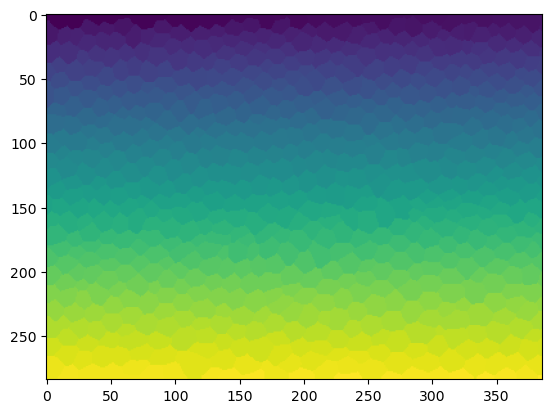

In [ ]:
## load a test segmentation & label it

segmentation_test = plt.imread('test_segmentation_small.tif')
labeled_gap = ndimage.label(segmentation_test==0)[0]
labeled_test = expand_labels(labeled_gap, distance=2)

plt.imshow(labeled_test)

In [ ]:
%timeit _ = future.graph.RAG(label_image=labeled_test, connectivity=1)

252 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Wheel of qualitative colors in matplotlib

Curse `matplotlib` for not providing this out of the box

In [ ]:
#| export

def for_imshow(labeled: NDArray[Shape["*,*"], Int], colors: NDArray[Shape["*,3"], Float]=drs.fridtjof_colors
              ) -> NDArray[Shape["*,*,3"], Float]:
    """Create colored array from labeled image using array of RBG colors, with black boundaries."""
    bdry = segmentation.find_boundaries(labeled, mode='outer')
    rgb = colors[labeled % colors.shape[0]]
    rgb = (rgb.transpose((2,0,1)) * (bdry == 0)).transpose((1,2,0))
    return rgb

<matplotlib.image.AxesImage>

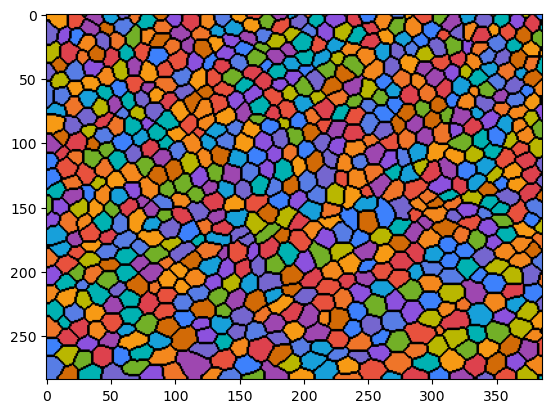

In [ ]:
plt.imshow(for_imshow(labeled_test))

### create a region connectivity graph from a labeled image.

This is copied from `skimage.future.graph` - but I don't want to depend on this module, which is currently alpha.

Graphs are modeled using dictionaries, where nodes are keys, and entries are the list of neighbors. The dictionary values are sets so as to automatically remove duplicates

In [ ]:
myset = {1, 2, 3}
myset.add(4)
myset.add(2)
myset

{1, 2, 3, 4}

In [ ]:
#| export

def _add_edge_filter(values, graph_dict):
    """Create edge in `graph_dict` between central element of `values` and the rest.
    Add an edge between the middle element in `values` and
    all other elements of `values` into `graph`.  ``values[len(values) // 2]``
    is expected to be the central value of the footprint used.
    Parameters
    ----------
    values : array
        The array to process.
    graph_dict : dict
        The graph to add edges in.
    Returns
    -------
    0 : float
        Always returns 0. The return value is required so that `generic_filter`
        can put it in the output array, but it is ignored by this filter.
    """
    values = values.astype(int)
    center = values[len(values) // 2]
    for value in values:
        if value != center:
            graph_dict[center].add(value)
    return 0.

In [ ]:
#| export

def _4fold_filter(values, graph_dict):
    """
    Create edges in `graph_dict` for 4-fold vertices which meet in the square configuration.
    
    To avoid 
    
    Parameters
    ----------
    values : array
        The array to process. Should to be of shape 4 from a 2x2 strelm
    graph_dict : dict
        The graph to add edges in.
    Returns
    -------
    0 : float
        Always returns 0. The return value is required so that `generic_filter`
        can put it in the output array, but it is ignored by this filter.
    """
    values = values.astype(int)
    if np.unique(values).size == values.size:
        graph_dict[values[0]].add(values[3])
        graph_dict[values[3]].add(values[0])
    return 0.

In [ ]:
def labeled_to_graph(label_image: NDArray[Shape["*,*"], Int], connectivity=1) -> Dict[int, set]:
    """
    Create region adjacency graph from labeled image.
    
    Returns a graph whose nodes are labeled regions in the input image, and where nodes are connected
    if they are adjacent as measured by pixel connectivity. 
    
    The graph is a dict whose keys are the nodes, and where the value at a key are the neighbors of
    a node. This code is taken from `skimage.future.graph.RAG`

    Parameters
    ----------
    label_image: 2d array of ints
        Labeled input image
    connectivity: int, default 1
        Don't change this or unexpected behavior may occur downstream.
    
    Returns
    -------
    graph_dict: dict
        Connectivity graph
    
    """

    graph_dict = {key: set() for key in np.unique(label_image)}
    fp = ndimage.generate_binary_structure(label_image.ndim, connectivity)
    # In the next ``ndi.generic_filter`` function, the kwarg
    # ``output`` is used to provide a strided array with a single
    # 64-bit floating point number, to which the function repeatedly
    # writes. This is done because even if we don't care about the
    # output, without this, a float array of the same shape as the
    # input image will be created and that could be expensive in
    # memory consumption.
    output = np.lib.stride_tricks.as_strided(np.empty((1,), dtype=float),
                                             shape=label_image.shape, strides=((0,) * label_image.ndim))
    
    ndimage.generic_filter(label_image, function=_add_edge_filter, footprint=fp, mode='nearest',
                           output=output, extra_arguments=(graph_dict,))

    fp_4fold = np.ones((2,2))
    ndimage.generic_filter(label_image, function=_4fold_filter, footprint=fp_4fold, mode='nearest',
                           output=output, extra_arguments=(graph_dict,))

    graph_dict = {int(key): val for key, val in graph_dict.items()}
    
    return graph_dict

In [ ]:
graph_test = labeled_to_graph(labeled_test)

In [ ]:
%timeit labeled_to_graph(labeled_test)

905 ms ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
## plot this if desired ...

## Identifiying faces

Now, we need to identify the faces, i.e. triangles. Because we are looking for triangles, i.e. length 3 cycles, this can be done in a rather brute force manner.

In [ ]:
def get_triangles(graph_dict):
    """Get all cycles of length 3 from a graph in dict {node: [neighbors]}-format"""
    triangles = set()
    for node in graph_dict.keys():
        for neighbor in graph_dict[node]:
            for next_neighbor in graph_dict[neighbor]:
                if node in graph_dict[next_neighbor]:
                    triangles.add(tuple(sorted([node, neighbor, next_neighbor])))
    return triangles

In [ ]:
%timeit get_triangles(graph_test)

8.59 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 4-fold vertices



[DEPRECATED:] At 4-fold vertices, the connectivity-scanning algorithm to build the adjacency graph can lead to two overlapping triangles:

```
X----X
| \/ |
| /\ |
X----X
```

These need to be removed since they spoil many properties of the triangle mesh (it is no longer a manifold: force balance, isogonal modes, and edge flips are ill-defined, mesh traversal algorithms don't work, ...)

The tell-tall sign of such are edges which are contained in 3 triangles. Otherwise, an edge is always contained in 2 triangles (1 if it is a boundary). Triangle which have two 3-triangle edges are part of a 4-fold vertex configuration. One of them must be removed (decided arbitrarily by alphanumerical order).

As long as we use a structuring element with connectivity 1, and the segmentation contains no cells with pixel size 1 (or purely diagonally connected regions), "worse" than 4-fold cannot occur.

[TO DO: Need to make a routine to check - and if required, sanitize input.]


Actually, the problem is the inverse: with the connectivity-1 structuring element, the 4-fold vertex configuration cannot occur. Instead, we have the following problem. In a "square" 4-fold meeting point, _no_ diagonal link is created:
```
0 1 
3 2 
```
has links `(0,1), (1,2), (2,3), (30)`. But no others. This can be fixed by another pass with a `2x2` structuring element. 


other potentially problematic cases: highly non-convex cells which meet multiple times

In [ ]:
#| export


def prepare_input(segmentation):
    
    pass

<matplotlib.image.AxesImage>

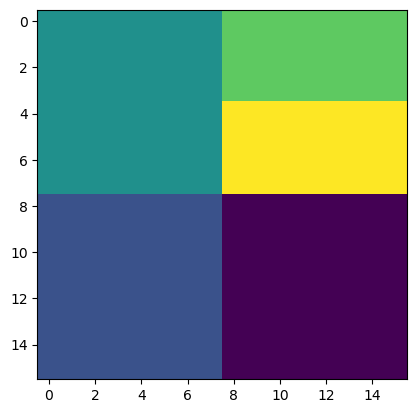

In [ ]:
## creating a test array

test_4fold = np.zeros((16, 16))

test_4fold[8:,8:] = 0
test_4fold[8:,:8] = 1
test_4fold[:8,:8] = 2
test_4fold[:4,8:] = 3
test_4fold[4:8,8:] = 4

#test_4fold[7, 8] = 2 # to trigger problem

plt.imshow(test_4fold)
# this contains 1 3-fold and one 4 fold vertex

In [ ]:
graph_4fold = labeled_to_graph(test_4fold)

graph_4fold

{0: {1, 2, 4}, 1: {0, 2}, 2: {0, 1, 3, 4}, 3: {2, 4}, 4: {0, 2, 3}}

In [ ]:
get_triangles(graph_4fold)  # missing triangles!

{(0, 1, 2), (0, 2, 4), (2, 3, 4)}

<matplotlib.image.AxesImage>

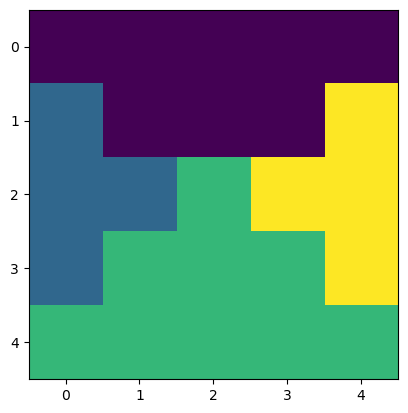

In [ ]:
test_4fold2 = np.array([[0, 0, 0, 0, 0],
                        [1, 0, 0, 0, 3],
                        [1, 1, 2, 3, 3],
                        [1, 2, 2, 2, 3],
                        [2, 2, 2, 2, 2],
                       ])

plt.imshow(test_4fold2)

In [ ]:
graph_4fold2 = labeled_to_graph(test_4fold2)

graph_4fold2

{0: {1, 2, 3}, 1: {0, 2}, 2: {0, 1, 3}, 3: {0, 2}}

In [ ]:
get_triangles(graph_4fold2)

{(0, 1, 2), (0, 2, 3)}

## temporarily set the vertices dual vertices to cell centroid positions & create `HalfEdgeMesh`

In [ ]:
#| export

def get_com_dict(labeled: NDArray[Shape["*,*"], Int]) -> Dict[int, NDArray[Shape["2"], Float]]: 
    """Get the centroids of regions in a labeled array"""
    return {key: np.array(ndimage.center_of_mass(labeled==key)) for key in np.unique(labeled)}
        

In [ ]:
%timeit get_com_dict(labeled_test)

317 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


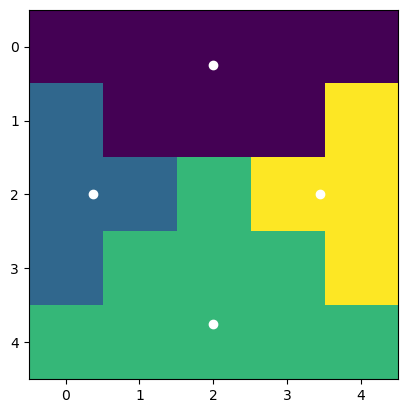

In [ ]:
plt.imshow(test_4fold2)

for val in get_com_dict(test_4fold2).values():
    plt.scatter(*val, color='w')
    

In [ ]:
tri_4fold2 = get_triangles(labeled_to_graph(test_4fold2))
points_4fold2 = get_com_dict(test_4fold2)

# re-number etc. this is problematic in as far we want the vertex labels to reflect the
# labels of the segmentation!
sorted_vertices = sorted(points_4fold2.keys())
vertex_to_ix = {key: ix for ix, key in enumerate(sorted_vertices)}

tri_4fold2 = [[vertex_to_ix[x] for x in tri] for tri in tri_4fold2]
points_4fold2 = np.array([points_4fold2[key] for key in sorted_vertices])

hemesh_4fold2 = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(points_4fold2, tri_4fold2))

hemesh_4fold2.is_consistent()

True

<matplotlib.image.AxesImage>

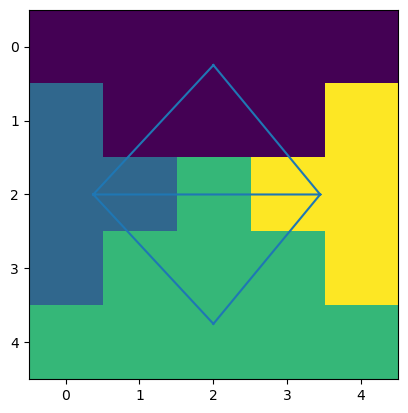

In [ ]:
hemesh_4fold2.triplot()
plt.imshow(test_4fold2)


In [ ]:
help(msh.ListOfVerticesAndFaces)

Help on class ListOfVerticesAndFaces in module CE_simulation.mesh:

class ListOfVerticesAndFaces(builtins.object)
 |  ListOfVerticesAndFaces(vertices, faces, neighbors=None)
 |  
 |  Simplest data structure for a triangulation, comprises:
 |      - Vertices = [($x_0$,$y_0$), ... ]
 |      - Triangles = [(vertex id 1, vertex id 2, vertex id 3), ...]
 |  From this data, one can compute the neighbor relationship of triangles
 |      - Triangle neighbors = [(triangle id 1, triangle id 2, triangle id 3), ...]
 |  
 |  Methods defined here:
 |  
 |  __init__(self, vertices, faces, neighbors=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_combined_edges(self)
 |      Get a list of unique edges. Edges are a tuple ((vert 1, vert 2), (face 1, face 2)). Boundary edges 
 |      have face 1 None.
 |  
 |  remove_face(self, f_id)
 |  
 |  remove_vertex(self, v_id)
 |      # some basic methods
 |  
 |  save_obj(self: CE_simulation.mesh.ListOfVerticesAndFaces,

## Finding primal vertices

Next, we need to find the cell vertices - corners of the cell polygons, where 3 (or more...) cells meet. And we need to match them to the corresponding triangles, too!

A vertex can be found where the 1-connectivity structuring element has two distinct neighbors

OR where the 4-vertex element exists.

so we can use similar code to the above.

By necessity, a vertex will be extended area 4 for 4 vertex area. Can shrink by skeletonize.

Then, re-dilate using 1-connectivity and find the unique elements nearby, as well as x/y coord using a for loop + numpy nonzero.